# 2 Modeling <a id='1_modeling'></a>

## 2.1 Contents<a id='2.1_Contents'></a>
* [2 Modeling](#2_modeling)
  * [2.1 Contents](#2.1_Contents)
  * [2.2 Introduction](#2.2_Introduction)
  * [2.3 Imports](#2.3_Imports)
  * [2.4 Load Image Numpy Arrays](#2.4_load_images)
  * [2.5 Define Functions](#2.5_functions)
  * [2.6 Model Selection and Tuning](#2.6_model_selection)
      * [2.6.1 Pre-trained model and hyperparameters](#2.6.1_pre_model) 
      * [2.6.2 Further training](#2.6.2_training) 
  * [2.7 Evaluation](#2.7_evaluation)
      * [2.7.1 Evaluation Set](#2.7.1_evaluation_set)
      * [2.7.2 Individual Images](#2.7.2_individual) 
  * [2.8 Conclustion](#2.8_conclusion)      

## 2.2 Introduction<a id='2.2_Introduction'></a>

This notebook completes the work in using images extracted from videos to train a convolutional neural network model to classify leaves as oak or maple.

To build this model, a pre-trained model is used replacing the last layer with one that represents two classes. Three different pre-trained models were experimented with--NasNetMobile, DenseNet169, and InceptionResNetV2. In addition, different hyperparameters were varied to choose the model that achieves the best accuracy.

## 2.3 Imports<a id='2.3_Imports'></a>

In [ ]:
# !pip install keras.applications
# ! pip install keras
# ! pip install sklearn

In [2]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [3]:
from keras.applications.nasnet import NASNetMobile
from keras.applications import DenseNet169
from keras.applications import InceptionResNetV2

In [4]:
import h5py

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## 2.4 Load Image Numpy Arrays<a id='2.4_load_images'></a>

In [5]:
# images for training are in image_arrays folder
# images for evaluation are in evaluation_set

# for training
root = 'image_arrays/'

In [8]:
os.listdir(root)

['y_color', 'X_color', '.ipynb_checkpoints']

In [9]:
# assign the correct folders to variables folderX and foldery
folder = os.listdir(root)
if 'X' in folder[0]:
    folderX = folder[0]
    foldery = folder[1]
elif 'X' in folder[1]:
    folderX = folder[1]
    foldery = folder[0]
else:
    print('error in directory')

In [10]:
# create lists of numpy array filenames
# these files need to be in chronological order
folderX_files = sorted(os.listdir(root + folderX))
foldery_files = sorted(os.listdir(root + foldery))

print(folderX_files)
print(foldery_files)

['.ipynb_checkpoints', 'X0_eval.npy', 'X1_eval.npy', 'X2_eval.npy', 'X3_eval.npy']
['.ipynb_checkpoints', 'y0_eval.npy', 'y1_eval.npy', 'y2_eval.npy', 'y3_eval.npy']


In [11]:
# load an example file
Xi = np.load(root + folderX + '/'+ 'X0_eval.npy', allow_pickle=False)
yi = np.load(root + foldery + '/'+ 'y0_eval.npy', allow_pickle=False)

Xi.shape # this is one chunk of the total images
yi.shape

In [ ]:
i = 20
print(yi[i])  # check that label corresponds to image: 0-oak, 1-maple
_ = plt.imshow(Xi[i])
plt.show()

## 2.5 Define functions<a id='2.5_functions'></a>

In [56]:
# function to take a pre-trained model and create a complete model
# that makes a binary prediction


def create_model(pre_model, weights_path=None, activation='sigmoid', loadWeights=False):
    
    pre_model.trainable = False # layers from the pre-trained model are frozen (not trainable)

    input_shape = (224,224,3)
    # set model constants
    num_classes = 1
    # define model as Sequential
    model = Sequential()
    model.add(pre_model)
    # prediction layers
    model.add(Dense(num_classes, activation=activation, name='preds'))

    if loadWeights:
        model.load_weights(weights_path) # weights can be loaded if provided 
    return model

In [54]:
def train_model(model, lr, loss, optimizer, batch_size=32, epochs=5, cycles=1):
    for cycle in range(1,cycles+1):
        for i,j in folder_pairs: # i is maple, j is oak
            root = 'image_arrays/'
            Xfilei, Xfilej = folderX_files[i],folderX_files[j]
            yfilei, yfilej = foldery_files[i],foldery_files[j]  
            Xi = np.load(root + folderX + '/'+ Xfilei, allow_pickle=False)
            Xj = np.load(root + folderX + '/'+ Xfilej, allow_pickle=False)
            yi = np.load(root + foldery + '/'+ yfilei, allow_pickle=False)
            yj = np.load(root + foldery + '/'+ yfilej, allow_pickle=False)
            print('-----------------')
            print('cycle_num: ', cycle)
            print(i,j)
            print(Xfilei, Xfilej, yfilei, yfilej)
            
            optimizer.learning_rate=lr
            
            print(optimizer)
            print('lr= {}, loss={}'.format(optimizer.learning_rate,loss))
  
            X = np.append(Xi,Xj, axis=0)
            y = np.append(yi,yj,axis=0)
            X = X.reshape((-1,224,224,3))
            y = y.reshape((-1,1))
            print(X.shape, y.shape)

            # split remaining data into train and test sets
            x_train, x_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      test_size=0.2,
                                                      random_state=52)

            # examine number of samples in train, test, and validation sets
            print('x_train shape:', x_train.shape)
            print(x_train.shape[0], 'train samples')
            print(x_test.shape[0], 'test samples')

            

            model.compile(
                # set the loss as binary_crossentropy
                loss=loss,
                # set the optimizer as stochastic gradient descent
                optimizer=optimizer,
                # set the metric as accuracy
                metrics=['accuracy']
            )
            results = model.fit(
                x_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test))
            # model.save_weights('model_weights2.h5')   
    return model, results

## 2.6 Model Selection and Tuning<a id='2.6_model_selection'></a>

## 2.6.1 Pre-trained Model and Hyperparameters<a id='2.6.1_pre_model'></a>


In [ ]:
# weights_path = 'model_weights.h5'
# loadWeights = False

In [48]:
#folder_pairs = [(0,5),(1,6),(2,7),(3,8)]
folder_pairs = [(0,5),(1,6),(2,7),(3,8),(4,9)]
learn_rates = [0.1,0.001,0.00001]
loss_functions = ['binary_crossentropy']
optimizers = [keras.optimizers.SGD(), keras.optimizers.RMSprop()]

In [60]:
# Select NasNetMobile as pre-trained model
#pre_model = NASNetMobile(input_shape=(224,224,3), include_top=False, 
#                 weights='imagenet', input_tensor=None, pooling='avg')
#model = create_model(pre_model)
weights_file = 'start_weights_NNM.h5'
#model.save_weights(weights_file)
file_name = 'NasNetMobile_tuning_log2.txt'

In [13]:
pre_model = DenseNet169(input_shape=(224,224,3), include_top=False, 
                weights='imagenet', input_tensor=None, pooling='avg')
model = create_model(pre_model)
weights_file = 'start_weights_DN169.h5'
model.save_weights(weights_file)
file_name = 'DenseNet169_tuning_log.txt'

In [ ]:
pre_model = InceptionResNetV2(input_shape=(224,224,3), include_top=False, 
                 weights='imagenet', input_tensor=None, pooling='avg')
model = create_model(pre_model)
weights_file = 'start_weights_IRNV2.h5'
model.save_weights(weights_file)
file_name = 'InceptionResNetV2_tuning_log.txt'

In [61]:
cycles = 1
batch_size=28
epochs=3

for lr in learn_rates:
    for loss in loss_functions:
        for optimizer in optimizers:
            print(str(datetime.datetime.today()))
            print(pre_model.name)
            model.load_weights(weights_file)
            model, results = train_model(model, lr, loss, optimizer, batch_size=batch_size, epochs=epochs, cycles=cycles)
            val_acc = results.history['val_accuracy'][-1]
            
            # test model on unseen evaluation set
            eval_loss, eval_acc = model.evaluate(x_eval1,y_eval1)
            print('evaluation test -- accuracy = {}'.format(eval_acc))
            print('--------------------------------------------------------')
            results_string = '''lr: {}, loss: {},\n optimizer: {}, 
            pretrained_model: {}\n val_accuracy: {}\n evaluation acc: {}'''.format(lr, loss, optimizer, pre_model.name, val_acc, eval_acc)
            
            with open(file_name, 'a') as log:
                log.write(str(datetime.datetime.today()) + '\n')
                log.write(results_string + '\n' + '-----' + '\n')


2021-07-13 22:37:23.931909
NASNet
-----------------
cycle_num:  1
0 5
X0_color.npy X5_color.npy y0_color.npy y5_color.npy
lr= <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.1>, loss=binary_crossentropy
(1400, 224, 224, 3) (1400, 1)
x_train shape: (1120, 224, 224, 3)
1120 train samples
280 test samples
Epoch 1/3
40/40 [==============================] - 33s 557ms/step - loss: 0.7759 - accuracy: 0.6802 - val_loss: 0.7951 - val_accuracy: 0.6929
Epoch 2/3
40/40 [==============================] - 17s 434ms/step - loss: 0.3898 - accuracy: 0.8392 - val_loss: 0.3248 - val_accuracy: 0.8500
Epoch 3/3
40/40 [==============================] - 17s 433ms/step - loss: 0.3617 - accuracy: 0.8434 - val_loss: 0.3417 - val_accuracy: 0.8500
-----------------
cycle_num:  1
1 6
X1_color.npy X6_color.npy y1_color.npy y6_color.npy
lr= <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.1>, loss=binary_crossentropy
(1400, 224, 224, 3) (1400, 1)
x_train shape: (1120, 224, 224, 3)
1120 t

16/16 [==============================] - 10s 391ms/step - loss: 1.1908 - accuracy: 0.4420
evaluation test -- accuracy = 0.44200000166893005
2021-07-13 23:15:20.918461
NASNet
-----------------
cycle_num:  1
0 5
X0_color.npy X5_color.npy y0_color.npy y5_color.npy
lr= <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-05>, loss=binary_crossentropy
(1400, 224, 224, 3) (1400, 1)
x_train shape: (1120, 224, 224, 3)
1120 train samples
280 test samples
Epoch 1/3
40/40 [==============================] - 33s 567ms/step - loss: 0.6770 - accuracy: 0.5772 - val_loss: 0.7041 - val_accuracy: 0.5143
Epoch 2/3
40/40 [==============================] - 18s 448ms/step - loss: 0.6827 - accuracy: 0.5589 - val_loss: 0.7034 - val_accuracy: 0.5179
Epoch 3/3
40/40 [==============================] - 18s 444ms/step - loss: 0.6789 - accuracy: 0.5761 - val_loss: 0.7026 - val_accuracy: 0.5179
-----------------
cycle_num:  1
1 6
X1_color.npy X6_color.npy y1_color.npy y6_color.npy
lr= <tf.Variable 'learnin

## 2.6.2 Further Training<a id='2.6.2_training'></a>

Chosen model:
The DenseNet169 performed best. With the RMSprop optimizer it achieved high accuracy with test set at both 0.1 and 0.001 learning rates.

Now refine the model, training with complete data set and more epochs. 

In [ ]:
# weights_path = 'model_weights.h5'
# loadWeights = False

In [20]:
cycles = 1
batch_size=28
learn_rates = [0.1,0.001,0.0001] # train model at various learning rates
folder_pairs = [(0,5),(1,6),(2,7),(3,8),(4,9)] # complete data set of 7000 images
file_name = 'Final_model_training_log3.txt' # results of training stored to file

epochs=3 # three epochs per chunk per learning rate
loss = 'binary_crossentropy' # chosen loss function
optimizer = keras.optimizers.RMSprop() # chosen optimizer

for lr in learn_rates:
    print(str(datetime.datetime.today()))
    print('lr: {}'.format(lr))
    print(pre_model.name)
    model, results = train_model(model, lr, loss, optimizer, batch_size=batch_size, epochs=epochs, cycles=cycles)
    val_acc = results.history['val_accuracy'][-1]
    results_string = '''lr: {}, loss: {},\n optimizer: {}, 
    pretrained_model: {}\n val_accuracy: {}'''.format(lr, loss, optimizer, pre_model.name, val_acc)
    with open(file_name, 'a') as log:
        log.write(str(datetime.datetime.today()) + '\n')
        log.write(results_string + '\n' + '-----' + '\n')

2021-07-13 13:41:56.862831
lr: 0.1
densenet169
-----------------
cycle_num:  1
0 5
X0_color.npy X5_color.npy y0_color.npy y5_color.npy
lr= <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.1>, loss=binary_crossentropy
(1400, 224, 224, 3) (1400, 1)
x_train shape: (1120, 224, 224, 3)
1120 train samples
280 test samples
Epoch 1/3
40/40 [==============================] - 46s 996ms/step - loss: 4.7798 - accuracy: 0.8376 - val_loss: 0.6011 - val_accuracy: 0.9429
Epoch 2/3
40/40 [==============================] - 37s 934ms/step - loss: 1.1060 - accuracy: 0.9156 - val_loss: 2.8961 - val_accuracy: 0.8179
Epoch 3/3
40/40 [==============================] - 37s 935ms/step - loss: 1.0908 - accuracy: 0.9093 - val_loss: 2.0244 - val_accuracy: 0.8750
-----------------
cycle_num:  1
1 6
X1_color.npy X6_color.npy y1_color.npy y6_color.npy
lr= <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.1>, loss=binary_crossentropy
(1400, 224, 224, 3) (1400, 1)
x_train shape: (1120, 224, 2

(1400, 224, 224, 3) (1400, 1)
x_train shape: (1120, 224, 224, 3)
1120 train samples
280 test samples
Epoch 1/3
40/40 [==============================] - 45s 972ms/step - loss: 0.1542 - accuracy: 0.9747 - val_loss: 0.1581 - val_accuracy: 0.9750
Epoch 2/3
40/40 [==============================] - 36s 918ms/step - loss: 0.2282 - accuracy: 0.9702 - val_loss: 0.1575 - val_accuracy: 0.9750
Epoch 3/3
40/40 [==============================] - 36s 907ms/step - loss: 0.2250 - accuracy: 0.9728 - val_loss: 0.1567 - val_accuracy: 0.9750
-----------------
cycle_num:  1
1 6
X1_color.npy X6_color.npy y1_color.npy y6_color.npy
lr= <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>, loss=binary_crossentropy
(1400, 224, 224, 3) (1400, 1)
x_train shape: (1120, 224, 224, 3)
1120 train samples
280 test samples
Epoch 1/3
40/40 [==============================] - 49s 1s/step - loss: 0.1645 - accuracy: 0.9797 - val_loss: 0.3073 - val_accuracy: 0.9643
Epoch 2/3
40/40 [==============================

In [21]:
# save model
json_model = model.to_json() #save the model architecture to JSON file
with open('final_model_1.json', 'w') as json_file:
    json_file.write(json_model)
    
# save weights
weights_file = 'weights_final_model_1.h5'
model.save_weights(weights_file)

## 2.7 Evaluation<a id='2.7_evaluation'></a>

Because test images above were taken from the same videos that train images were taken from, there is a concern that there is leakage from the train set to the test set. Therefore, additional video was taken and images extracted and prepared as images were prepared above. These images were never seen by the model. The evaluation on two sets of these evaluation images is shown below.

In [ ]:
# evaluation set
root = 'evaluation_set/'
# assign the correct folders to variables folderX and foldery
folder = os.listdir(root)
if 'X' in folder[0]:
    folderX = folder[0]
    foldery = folder[1]
elif 'X' in folder[1]:
    folderX = folder[1]
    foldery = folder[0]
else:
    print('error in directory')
# create lists of numpy array filenames
# these files need to be in chronological order
folderX_files = sorted(os.listdir(root + folderX))
foldery_files = sorted(os.listdir(root + foldery))

print(folderX_files)
print(foldery_files)

In [13]:
# test model on evaluation set

folderX_files, foldery_files

(['.ipynb_checkpoints',
  'X0_eval.npy',
  'X1_eval.npy',
  'X2_eval.npy',
  'X3_eval.npy'],
 ['.ipynb_checkpoints',
  'y0_eval.npy',
  'y1_eval.npy',
  'y2_eval.npy',
  'y3_eval.npy'])

In [15]:
i, j = (1,3) # select 1 chunk from maple and oak each
Xfilei, Xfilej = folderX_files[i],folderX_files[j]
yfilei, yfilej = foldery_files[i],foldery_files[j]  
Xi = np.load(root + folderX + '/'+ Xfilei, allow_pickle=False)#maple
Xj = np.load(root + folderX + '/'+ Xfilej, allow_pickle=False)#oak
yi = np.load(root + foldery + '/'+ yfilei, allow_pickle=False)
yj = np.load(root + foldery + '/'+ yfilej, allow_pickle=False)

print(Xfilei, Xfilej, yfilei, yfilej)


-----------------
X0_eval.npy X2_eval.npy y0_eval.npy y2_eval.npy


In [16]:
X = np.append(Xi,Xj, axis=0) # append the two chunks to make X
y = np.append(yi,yj,axis=0)
X = X.reshape((-1,224,224,3))
y = y.reshape((-1,1))
print(X.shape, y.shape)

# make two shuffled sets of evaluation images
x_eval1, x_eval2, y_eval1, y_eval2 = train_test_split(X,
                                          y,
                                          test_size=0.5,
                                          random_state=52)

(1000, 224, 224, 3) (1000, 1)


[0]


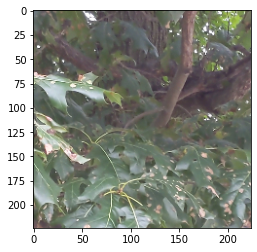

In [33]:
i = 76
x_eval1[i].shape
print(y_eval1[i]) # verify that image has correct label
plt.imshow(x_eval1[i])

In [17]:
x_eval1.shape

(500, 224, 224, 3)

In [5]:
# open the saved final model
with open('final_model_1.json', 'r') as json_file:
    json_savedModel= json_file.read()#load the model architecture 
model_final = keras.models.model_from_json(json_savedModel)
model_final.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 1664)              12642880  
_________________________________________________________________
preds (Dense)                (None, 1)                 1665      
Total params: 12,644,545
Trainable params: 1,665
Non-trainable params: 12,642,880
_________________________________________________________________


In [6]:
# load the saved weights to model
model_final.load_weights('weights_final_model_1.h5')

In [7]:
# define parameters for compiling
loss = 'binary_crossentropy'
optimizer = keras.optimizers.RMSprop()

In [8]:
# compile with the same parameters as training
model_final.compile(
                # set the loss as binary_crossentropy
                loss=loss,
                # set the optimizer as stochastic gradient descent
                optimizer=optimizer,
                # set the metric as accuracy
                metrics=['accuracy']
            )

## 2.7.1 Evaluation Set Results<a id='2.7.1_evaluation_set'></a>

In [34]:
# test final model on evaluation set 
model_final.evaluate(x_eval1,y_eval1)

16/16 [==============================] - 17s 838ms/step - loss: 0.2244 - accuracy: 0.9795


[0.2711501717567444, 0.9779999852180481]

In [35]:
model_final.evaluate(x_eval2,y_eval2)

16/16 [==============================] - 13s 806ms/step - loss: 0.2289 - accuracy: 0.9880


[0.22891360521316528, 0.9879999756813049]

The accuracy remains very high -- 98-99% -- on images unseen and unrelated to images seen by model. If there was leakage, it did not impact the model noticeably. 

## 2.7.2 Individual Images<a id='2.7.2_individual'></a>

Some individual images were selected from other videos not used in training. They were selected for demonstrating different possible obstacles to accurately classifying leaves -- high backlighting, small leaves, bad angles, and glare from the sun. 

In [35]:
def evaluate_image(npy_filename, model, root = 'pictures/'):
    if 'maple' in npy_filename:
        tree = (1,'maple')
    elif 'oak' in npy_filename:
        tree = (0, 'oak')
    else:
        return None
    image = np.load(root + npy_filename, allow_pickle=False)
    print(tree[1])
    _ = plt.imshow(image)
    plt.show()
    label = np.array([tree[0]])
    image = image.reshape((-1,224,224,3))
    label = label.reshape((-1,1))
    return model_final.evaluate(image,label) # returns loss, acc

In [37]:
eval_images = os.listdir('pictures')

maple


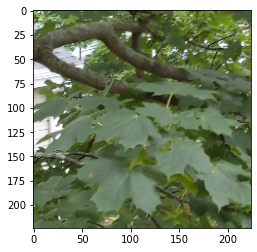

1/1 [==============================] - 0s 3ms/step - loss: 1.0420e-12 - accuracy: 1.0000
maple


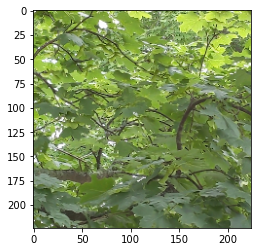

1/1 [==============================] - 0s 4ms/step - loss: 74.7203 - accuracy: 0.0000e+00
maple


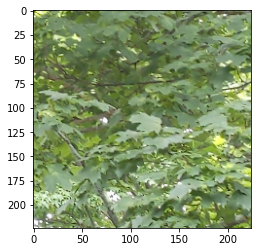

1/1 [==============================] - 0s 2ms/step - loss: 3.0341e-07 - accuracy: 1.0000
maple


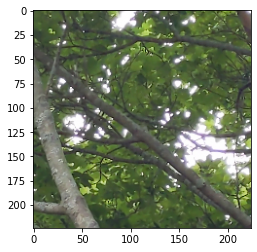

1/1 [==============================] - 0s 3ms/step - loss: 1.1943 - accuracy: 0.0000e+00
oak


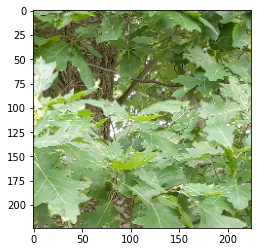

1/1 [==============================] - 0s 6ms/step - loss: 2.9262e-11 - accuracy: 1.0000
oak


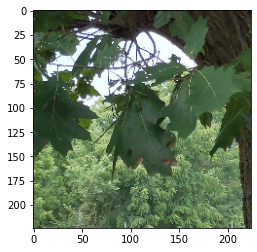

1/1 [==============================] - 0s 3ms/step - loss: 7.5015e-19 - accuracy: 1.0000
oak


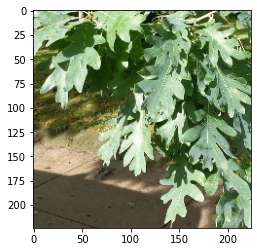

1/1 [==============================] - 0s 2ms/step - loss: 2.9660e-06 - accuracy: 1.0000
oak


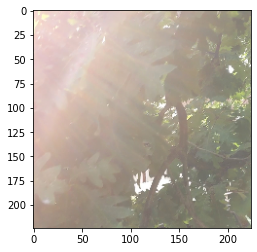

1/1 [==============================] - 0s 1ms/step - loss: 4.5663e-06 - accuracy: 1.0000


In [38]:
for image in eval_images:
    evaluate_image(image, model_final)

Out of 8 sample images, 6 were evaluated accurately. The two that were not suffered from a dense field of small, indistinct leaves and, in one, strong backlighting.

## 2.8 Conclusion<a id='2.8_conclusion'></a>

The model developed from the DenseNet169 pre-trained model proved to be very accurate (~98%) in classifying maple or oak leaves from images extracted from video.

Further work could be done to train a more robust model that could handle a greater variety of images.